In [1]:
#Some of these libraries are likely not necessary. Have not yet tested to determine which. Likely most of the dask libraries are unnecessary because we are only using a single GPU.

import time
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from natsort import natsorted

import cupy as cp
import cupyx as cpx
import cupyx
import cugraph

import cudf
import math

import h5py
import scipy

import dask
import dask_cudf
import rmm

from dask_cuda import initialize, LocalCUDACluster
from dask import delayed, dataframe
from dask.dataframe.utils import make_meta
from dask.distributed import Client, default_client
from dask_cuda.local_cuda_cluster import cuda_visible_devices
import dask.dataframe as dd

from cuml.manifold import TSNE, UMAP
from cuml.linear_model import LinearRegression

from sklearn.decomposition import PCA
from cuml.dask.cluster import KMeans as cu_dask_KMeans
from cuml.dask.manifold import UMAP as cu_dask_UMAP
from cuml.dask.linear_model import LinearRegression as cu_dask_LinearRegression
from cuml.dask.neighbors import NearestNeighbors as cu_dask_NearestNeighbors

#These need to present as .py files in the directory.
import rapids_scanpy_funcs as rsc
import utils as utils

#I'm not actually sure what this does, but I was told to include it by the RAPIDS manual.
import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

#This lets you oversubscribe memory on the GPU.
rmm.reinitialize(managed_memory=False)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

In [2]:
#Read in anndata as a pickle file from previous script.
with open('/scratch/hnatri/PIPAC/cell_merged_spatial_filtered_splitsamples', 'rb') as f:
    adata = pickle.load(f)

In [3]:
#Storing raw counts separately.
adata.raw = adata

In [4]:
sc.pp.log1p(adata)

In [5]:
sc.pp.scale(adata)

In [6]:
#Run PCA.
sc.tl.pca(adata, n_comps=50)

In [7]:
#Find neighbours. Make sure method is set to rapids or it won't run on the GPU.
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20, n_pcs=20, method='rapids')

In [8]:
#Leiden clustering. Have to add to keys by hand because key_added argument is not available. Note that this is a function from rapids_scanpy_funcs.py NOT from scanpy.
adata.obs["leiden_res0.5"] = rsc.leiden(adata, resolution=0.5)
adata.obs["leiden_res1.0"] = rsc.leiden(adata, resolution=1.0)
adata.obs["leiden_res1.5"] = rsc.leiden(adata, resolution=1.5)
adata.obs["leiden_res2.0"] = rsc.leiden(adata, resolution=2.0)

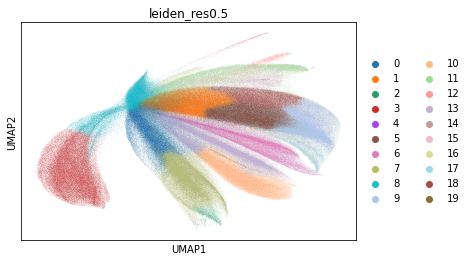

In [9]:
#Run UMAP. Make sure method is set to rapids or it won't run on the GPU.
sc.tl.umap(adata, random_state=42, method='rapids')
sc.pl.umap(adata, color='leiden_res0.5')

In [10]:
adata.X = sc.pp.log1p(adata.raw.X, copy=True)

In [11]:
#adata.obs["annot1"].unique()

In [12]:
#Cast int32 variables to float64 so that the object can be converted back to Seurat. Note that int64 may work as well, but I haven't tested it.
adata.obs["transcript_counts"] = adata.obs["transcript_counts"].astype('float64')
adata.obs["control_probe_counts"] = adata.obs["control_probe_counts"].astype('float64')
adata.obs["genomic_control_counts"] = adata.obs["genomic_control_counts"].astype('float64')
adata.obs["control_codeword_counts"] = adata.obs["control_codeword_counts"].astype('float64')
adata.obs["unassigned_codeword_counts"] = adata.obs["unassigned_codeword_counts"].astype('float64')
adata.obs["deprecated_codeword_counts"] = adata.obs["deprecated_codeword_counts"].astype('float64')
adata.obs["total_counts"] = adata.obs["total_counts"].astype('float64')
adata.obs["nucleus_count"] = adata.obs["nucleus_count"].astype('float64')
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype('float64')
adata.obs["nFeature_cell_RNA"] = adata.obs["nFeature_cell_RNA"].astype('float64')

In [13]:
#Write anndata to h5 file to import into R for conversion to Seurat object. Next move to commandline R for sceasy.
adata.write_h5ad(filename="/scratch/hnatri/PIPAC/cell_merged_spatial_filtered_splitsamples_clustered_NC50_NN20_PC20_AnnData.h5ad")

In [14]:
adata.obs.dtypes


cell_id                         object
x_centroid                     float64
y_centroid                     float64
transcript_counts              float64
control_probe_counts           float64
genomic_control_counts         float64
control_codeword_counts        float64
unassigned_codeword_counts     float64
deprecated_codeword_counts     float64
total_counts                   float64
cell_area                      float64
nucleus_area                   float64
nucleus_count                  float64
segmentation_method           category
orig.ident                    category
nCount_RNA                     float64
nFeature_RNA                   float64
num.blank                      float64
TMA                           category
percent.blank                  float64
nCount_cell_RNA                float64
nFeature_cell_RNA              float64
Sample                        category
ident                         category
leiden_res0.5                 category
leiden_res1.0            

In [15]:
adata.raw.X

array([[0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
adata.obs

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,...,TMA,percent.blank,nCount_cell_RNA,nFeature_cell_RNA,Sample,ident,leiden_res0.5,leiden_res1.0,leiden_res1.5,leiden_res2.0
S21-24369_2A_TMA1_aaaafhkm-1_1,S21-24369_2A_TMA1_aaaafhkm-1_1,3120.634766,3213.420898,34.0,0.0,0.0,0.0,0.0,0.0,34.0,...,MR_PIPAC-TMA1,0.0,34.0,22.0,S21-24369_2A,SeuratProject,8,10,0,57
S21-7951_5A_TMA1_aaabeech-1_1,S21-7951_5A_TMA1_aaabeech-1_1,3260.058350,5974.840820,153.0,0.0,0.0,0.0,0.0,0.0,153.0,...,MR_PIPAC-TMA1,0.0,153.0,72.0,S21-7951_5A,SeuratProject,17,22,29,80
S21-7951_5A_TMA1_aaabidlm-1_1,S21-7951_5A_TMA1_aaabidlm-1_1,3167.581055,6008.589844,68.0,0.0,0.0,0.0,0.0,0.0,68.0,...,MR_PIPAC-TMA1,0.0,68.0,37.0,S21-7951_5A,SeuratProject,17,22,29,80
S21-7951_5A_TMA1_aaacanmk-1_1,S21-7951_5A_TMA1_aaacanmk-1_1,3158.915039,6016.890137,45.0,0.0,0.0,0.0,0.0,0.0,45.0,...,MR_PIPAC-TMA1,0.0,45.0,31.0,S21-7951_5A,SeuratProject,17,22,29,80
S21-7951_5A_TMA1_aaacnggd-1_1,S21-7951_5A_TMA1_aaacnggd-1_1,3176.202393,6007.105957,194.0,0.0,0.0,0.0,0.0,0.0,194.0,...,MR_PIPAC-TMA1,0.0,194.0,88.0,S21-7951_5A,SeuratProject,17,22,29,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SF230912-002063_TMA9_oiihhpok-1_10,SF230912-002063_TMA9_oiihhpok-1_10,6426.154785,17198.412109,144.0,0.0,0.0,0.0,0.0,0.0,144.0,...,MR_PIPAC-TMA9,0.0,144.0,62.0,SF230912-002063,SeuratProject,17,22,29,80
SF230912-002063_TMA9_oijepkmk-1_10,SF230912-002063_TMA9_oijepkmk-1_10,7550.663086,18705.533203,33.0,0.0,0.0,0.0,0.0,0.0,33.0,...,MR_PIPAC-TMA9,0.0,33.0,19.0,SF230912-002063,SeuratProject,0,0,5,33
SF230912-002063_TMA9_oijgbmpa-1_10,SF230912-002063_TMA9_oijgbmpa-1_10,7430.755859,18293.230469,11.0,0.0,0.0,0.0,0.0,0.0,11.0,...,MR_PIPAC-TMA9,0.0,11.0,10.0,SF230912-002063,SeuratProject,0,8,22,69
SF230912-002063_TMA9_oijihpmh-1_10,SF230912-002063_TMA9_oijihpmh-1_10,7460.930176,18464.236328,313.0,0.0,0.0,0.0,0.0,0.0,313.0,...,MR_PIPAC-TMA9,0.0,313.0,81.0,SF230912-002063,SeuratProject,7,12,15,60
